In [1]:
# imports
import html
import re
import string
from collections import Counter # like dict except returns 0 rather than key error
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import spacy
import pandas as pd
from gensim import corpora
from gensim.models import LdaModel

from data_loader import load_dataset

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/Subspace_Explorer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
nlp = spacy.load('en_core_web_sm')

# global var
RAND_SEED = 42
STOPWORDS = nlp.Defaults.stop_words
PROTECTED_WORDS = {'isis', 'news', 'texas', 'paris', 'alps'} # words not to lemmatize
SAVE_DIR = './results/analytics/' # set to None to disable saving

# colours for stances in plots
STANCE_COLORS = {
    'support': 'green',
    'deny': 'red',
    'query': 'blue',
    'comment': 'gray'
}

# use regex to remove patterns
RE_PATTERNS = [
    re.compile(r'https?://\S+|www\.\S+'), # url
    re.compile(r'@\w+'), # mentions
    re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
            u"\U00002702-\U000027B0" # <-- these are unicode ranges
            u"\U000024C2-\U0001F251"
            "]+", flags=re.UNICODE),
]

# event-specific words to remove (not super informative for stance analysis)
TOPIC_WORDS = [
    'charlie', 'hebdo', 'charliehebdo',
    'ebola', 'essien',
    'ferguson',
    'germanwings',
    'ottawa', 'shooting',
    'prince', 'toronto',
    'putin', 'missing',
    'sydney', 'siege', 'sydneysiege',
]
# comment out to include topic words in analysis
RE_PATTERNS.append(re.compile(r'\b(' + '|'.join(TOPIC_WORDS) + r')\b'))

sns.set_theme(style='whitegrid', font='Arial')

In [3]:
def tokenize(text, lemmatize=True):
    """Tokenize: lowercase, decode HTML entities, remove URLs, mentions, punctuation, stopwords, and optionally lemmatize."""
    text = text.lower()
    
    # decode HTML entities (&amp, etc.)
    text = html.unescape(text)
    
    # remove patterns w/ regex
    for pattern in RE_PATTERNS:
        text = pattern.sub(r'', text)
    
    # remove punct
    punct_table = str.maketrans('', '', string.punctuation)
    text = text.translate(punct_table)
    
    # tokenise, filter stopwords & lemmatise
    doc = nlp(text)
    if lemmatize:
        # protect certain words - otherwise lemmatise
        tokens = [
            t.text if t.text in PROTECTED_WORDS else t.lemma_
            for t in doc
            if t.text not in STOPWORDS and len(t.text) > 2 and not t.is_space
        ]
    else:
        # without lemmatisation for comparison
        tokens = [
            t.text for t in doc
            if t.text not in STOPWORDS and len(t.text) > 2 and not t.is_space
        ]
    
    return tokens

 # Analytics

In [4]:
# load dataset
train_df, dev_df, test_df = load_dataset()
all_df = pd.concat([train_df, dev_df, test_df])

Loading cached data from saved_data/datasets.pkl...


In [5]:
# class proportions
print("\nClass proportions in TRAIN set:")
print(train_df['label_text'].value_counts(normalize=True).mul(100))

print("\nClass proportions in DEV set:")
print(dev_df['label_text'].value_counts(normalize=True).mul(100))

print("\nClass proportions in TEST set:")
print(test_df['label_text'].value_counts(normalize=True).mul(100))


Class proportions in TRAIN set:
label_text
comment    64.511562
support    19.844266
deny        7.857480
query       7.786692
Name: proportion, dtype: float64

Class proportions in DEV set:
label_text
comment    61.565836
support    24.555160
query       9.964413
deny        3.914591
Name: proportion, dtype: float64

Class proportions in TEST set:
label_text
comment    74.165872
query      10.104862
support     8.960915
deny        6.768351
Name: proportion, dtype: float64


Saved: ./results/analytics/unigrams_by_stance.png


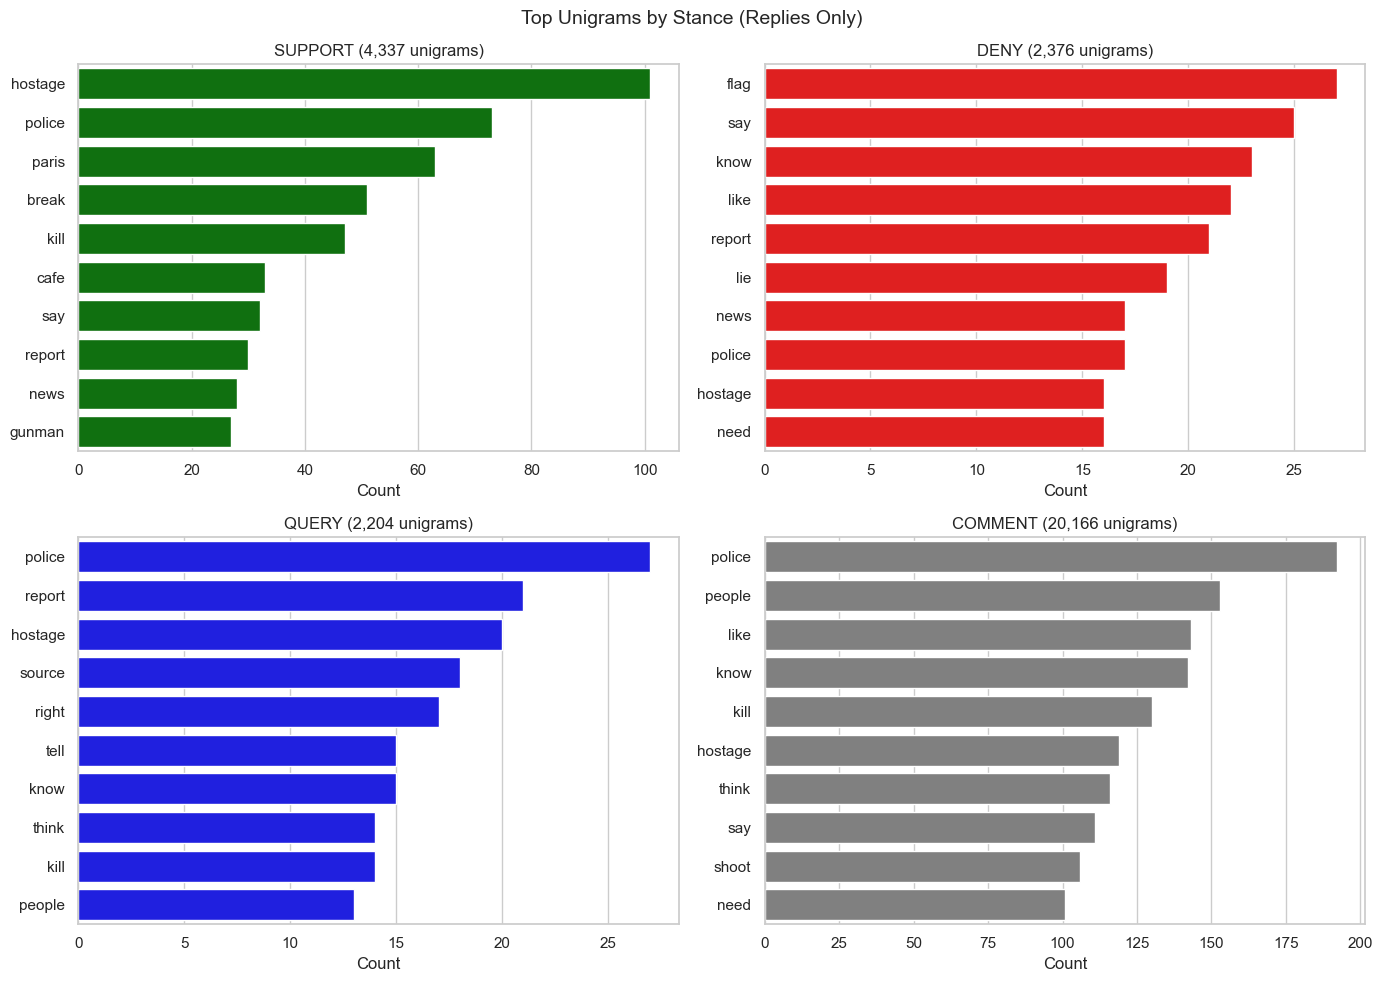

Saved: ./results/analytics/bigrams_by_stance.png


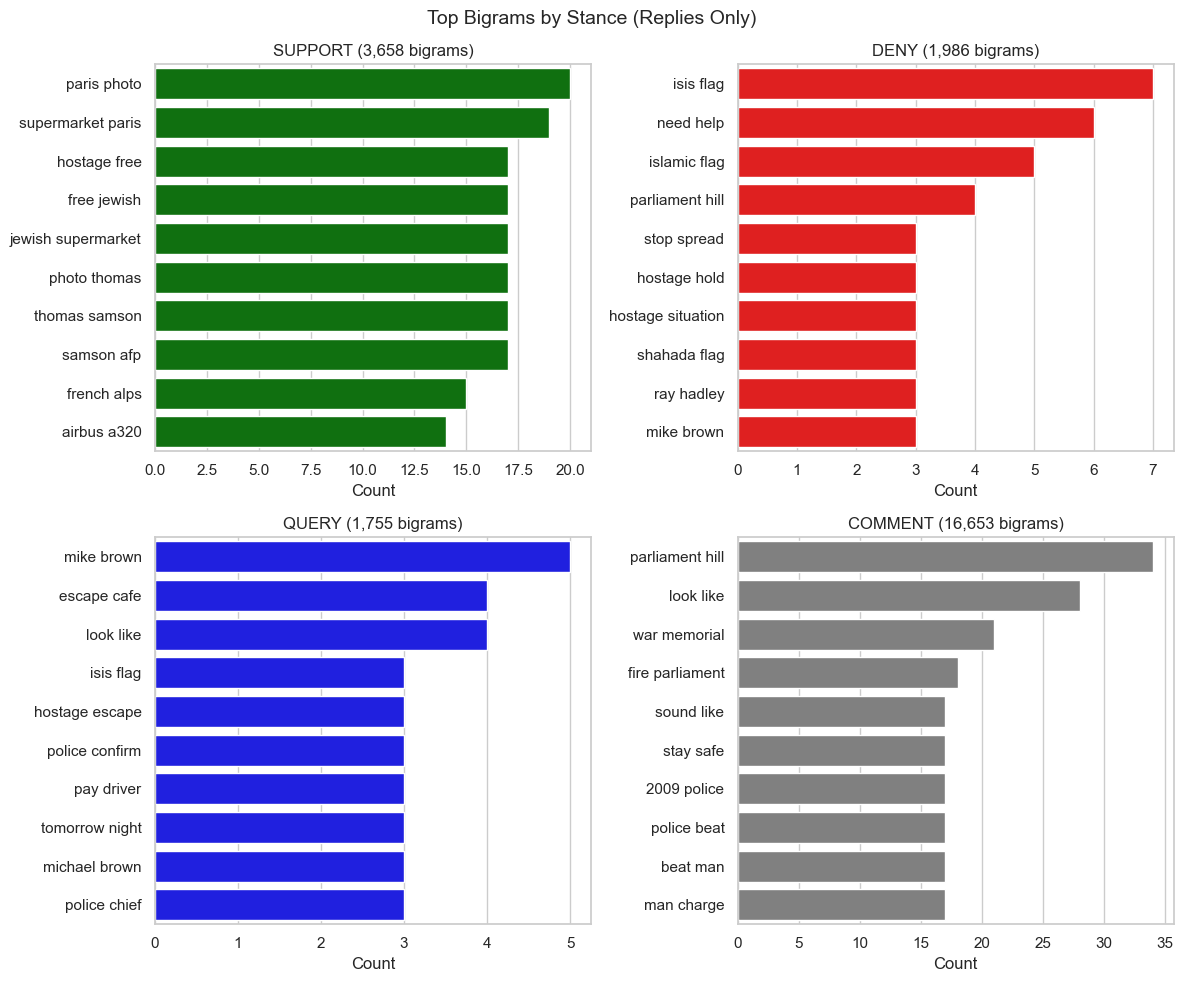

In [6]:
# (a) unigrams and bigrams

# 1 - vars
reply_df = all_df[all_df['source_id'].notna()] # only plot replies
top_n = 10 # top n to plot

# 2 - get unigrams and bigrams
def get_bigrams(tokens):
    """Generate bigrams from a list of tokens."""
    return [(tokens[i], tokens[i+1]) for i in range(len(tokens)-1)]

unigrams = {'support': Counter(), 'deny': Counter(), 'query': Counter(), 'comment': Counter()}
bigrams = {'support': Counter(), 'deny': Counter(), 'query': Counter(), 'comment': Counter()}

for _, row in reply_df.iterrows():
    tokens = tokenize(row['text'])
    unigrams[row['label_text']].update(tokens)
    bigrams[row['label_text']].update(get_bigrams(tokens))

# 3 - plot top unigrams and bigrams by stance
labels = ['support', 'deny', 'query', 'comment']    

# unigrams
_, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, label in zip(axes, labels):
    top_words = unigrams[label].most_common(top_n)
    n_tokens = sum(unigrams[label].values())
    if top_words:
        words, counts = zip(*top_words)
        sns.barplot(x=list(counts), y=list(words), ax=ax,
                    color=STANCE_COLORS[label], legend=False)
        ax.set_xlabel('Count')
        ax.set_title(f'{label.upper()} ({n_tokens:,} unigrams)')
    
plt.suptitle('Top Unigrams by Stance (Replies Only)', fontsize=14)
plt.tight_layout()
if SAVE_DIR: 
    plt.savefig(SAVE_DIR + 'unigrams_by_stance.png', dpi=150, bbox_inches='tight')
    print(f"Saved: {SAVE_DIR}unigrams_by_stance.png")
plt.show()

# bigrams
_, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, label in zip(axes, labels):
    top_bigrams = bigrams[label].most_common(top_n)
    n_bigrams = sum(bigrams[label].values())
    if top_bigrams:
        bigram_strs = [' '.join(b) for b, _ in top_bigrams]
        counts = [c for _, c in top_bigrams]
        sns.barplot(x=counts, y=bigram_strs, ax=ax,
                    color=STANCE_COLORS[label], legend=False)
        ax.set_xlabel('Count')
        ax.set_title(f'{label.upper()} ({n_bigrams:,} bigrams)')

plt.suptitle('Top Bigrams by Stance (Replies Only)', fontsize=14)
plt.tight_layout()
if SAVE_DIR: 
    plt.savefig(SAVE_DIR + 'bigrams_by_stance.png', dpi=150, bbox_inches='tight')
    print(f"Saved: {SAVE_DIR}bigrams_by_stance.png")
plt.show()

Saved: ./results/analytics/token_dist.png


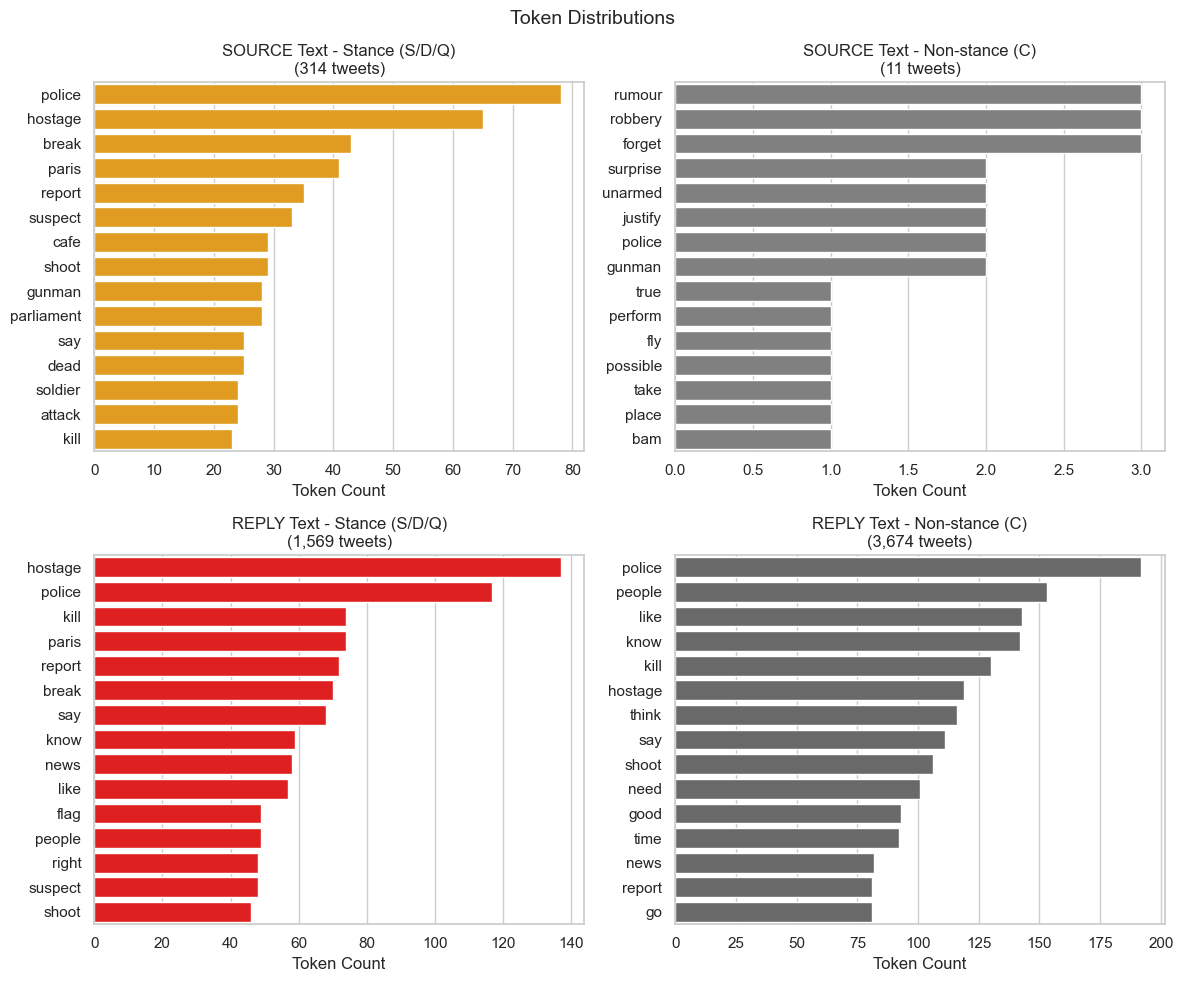

In [7]:
# (a) comparing token distributions

def compare_source_vs_reply_distributions(df):
    # 4 categories: source_stance, source_non_stance, reply_stance, reply_non_stance
    distributions = {
        'source_stance': Counter(),
        'source_non_stance': Counter(),
        'reply_stance': Counter(),
        'reply_non_stance': Counter(),
    }
    counts = {k: 0 for k in distributions}
    
    def process_row(row):
        tokens = tokenize(row['text'])
        is_source = row['source_id'] is None or (isinstance(row['source_id'], float) and pd.isna(row['source_id']))
        is_stance = row['label_text'] != 'comment'
        
        if is_source and is_stance:
            key = 'source_stance'
        elif is_source and not is_stance:
            key = 'source_non_stance'
        elif not is_source and is_stance:
            key = 'reply_stance'
        else:
            key = 'reply_non_stance'
        
        distributions[key].update(tokens)
        counts[key] += 1
    
    df.apply(process_row, axis=1)
    return {k: {'tokens': distributions[k], 'count': counts[k]} for k in distributions}

# 1 - vars
top_n = 15

# 2 - get distributions
distributions = compare_source_vs_reply_distributions(all_df)

# 3 - plot
_, axes = plt.subplots(2, 2, figsize=(12, 10))
plot_configs = [
    # (row, col, category, title, color)
    (0, 0, 'source_stance', 'SOURCE Text - Stance (S/D/Q)', 'orange'),
    (0, 1, 'source_non_stance', 'SOURCE Text - Non-stance (C)', 'gray'),
    (1, 0, 'reply_stance', 'REPLY Text - Stance (S/D/Q)', 'red'),
    (1, 1, 'reply_non_stance', 'REPLY Text - Non-stance (C)', 'dimgray'),
]

for row, col, key, title, color in plot_configs:
    ax = axes[row, col]
    data = distributions[key]
    tokens_counter = data['tokens']
    count = data['count']
    
    # top n tokens by frequency
    top_tokens = tokens_counter.most_common(top_n)
    
    if top_tokens:
        tokens, freqs = zip(*top_tokens)
        sns.barplot(x=list(freqs), y=list(tokens), ax=ax,
                    color=color, legend=False)
        ax.set_xlabel('Token Count')
        ax.set_ylabel('')
        ax.set_title(f'{title}\n({count:,} tweets)')
    else:
        print(f'no data for {key}!')

plt.suptitle('Token Distributions', fontsize=14)
plt.tight_layout()
if SAVE_DIR: 
    plt.savefig(SAVE_DIR + 'token_dist.png', dpi=150, bbox_inches='tight')
    print(f"Saved: {SAVE_DIR}token_dist.png")
plt.show()

In [12]:
# (b) LDA analysis

def get_topic_words(lda_model, n_words=20):
    topics = []
    for topic_id in range(lda_model.num_topics):
        # get_topic_terms returns (word_id, probability) pairs
        top_terms = lda_model.get_topic_terms(topic_id, topn=n_words)
        top_words = [(lda_model.id2word[word_id], prob) for word_id, prob in top_terms]
        topics.append(top_words)
    return topics

def print_topics(topics, title):
    print(f"{title} - LDA topics:")
    for i, topic in enumerate(topics):
        words = [w for w, _ in topic]
        print(f"[{i}]: {', '.join(words)}")

def create_wordcloud(topics, title, save_path=None):
    n_topics = len(topics)
    n_cols = (n_topics + 1) // 2
    n_rows = 2 if n_topics > 1 else 1
    
    _, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
    axes = axes.flatten() if n_topics > 1 else [axes]
    
    for i, topic in enumerate(topics):
        ax = axes[i]
        word_freq = {word: score for word, score in topic}
        wc = WordCloud(width=400, height=400, background_color='white',
                        max_words=50, min_font_size=12, prefer_horizontal=0.9)
        wc.generate_from_frequencies(word_freq)
        ax.imshow(wc, interpolation='bilinear')
        ax.set_title(f'Topic {i+1}', fontsize=14)
        ax.axis('off')
    
    # hide unused subplots if odd number of topics
    for j in range(n_topics, len(axes)):
        axes[j].axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    
    if save_path: 
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")
    plt.show()

# 1 - vars
n_topics = 8

# 2 - run LDA for each stance (use reply_df defined earlier to only plot replies)
stance_df = reply_df[reply_df['label_text'].isin(['support', 'deny', 'query'])]
comment_df = reply_df[reply_df['label_text'] == 'comment']

print(f"\nStance samples (S/D/Q): {len(stance_df)}")
print(f"Comment samples: {len(comment_df)}")

# tokenize
stance_texts = stance_df['text'].apply(tokenize).tolist()
comment_texts = comment_df['text'].apply(tokenize).tolist()

# build corpus and dictionary
stance_id2word = corpora.Dictionary(stance_texts)
stance_corpus = [stance_id2word.doc2bow(text) for text in stance_texts]

comment_id2word = corpora.Dictionary(comment_texts)
comment_corpus = [comment_id2word.doc2bow(text) for text in comment_texts]

# train LDA models
stance_lda = LdaModel(
    corpus=stance_corpus, id2word=stance_id2word, num_topics=n_topics,
    passes=20, random_state=RAND_SEED, alpha='auto', eta='auto'
)
comment_lda = LdaModel(
    corpus=comment_corpus, id2word=comment_id2word, num_topics=n_topics,
    passes=20, random_state=RAND_SEED, alpha='auto', eta='auto'
)


Stance samples (S/D/Q): 1569
Comment samples: 3674


Stance Replies (S/D/Q) - LDA topics:
[0]: right, shoot, soldier, help, need, brown, kill, say, police, look, good, like, cop, get, stop, wilson, officer, agree, confirm, release
[1]: flag, isis, islamic, tell, break, hostage, yes, confirm, cafe, gunman, report, lie, need, news, know, day, see, cop, right, dirty
[2]: hostage, paris, photo, police, say, break, supermarket, afp, free, cafe, jewish, situation, kill, people, samson, thomas, dead, live, update, kosher
[3]: hostage, hold, cafe, people, emergency, robbery, matter, lindt, pilot, think, report, state, store, news, ill, 911, well, say, suspect, actually
[4]: shoot, break, attack, happen, parliament, police, report, news, stop, try, video, hill, come, paris, soldier, lie, close, make, thank, shop
[5]: kill, french, crash, know, police, alps, airbus, near, black, a320, digne, hour, united, say, vigilante, safe, states, male, thank, news
[6]: good, like, uber, muslim, right, wrong, high, time, driver, hear, think, pay, get, tweet, w

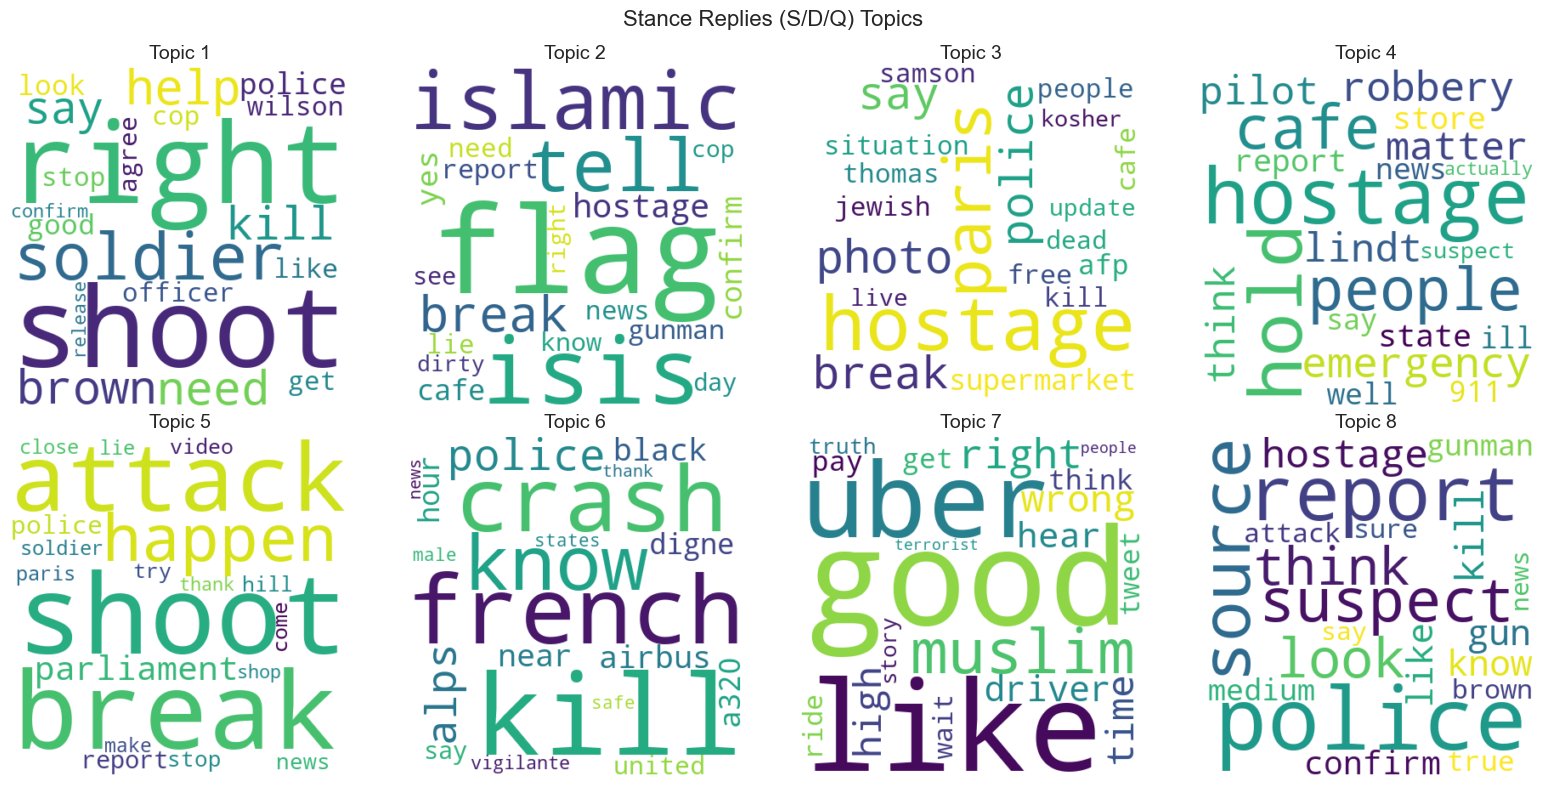

Comment Replies - LDA topics:
[0]: like, look, religion, time, send, safe, trump, think, yes, update, guy, rip, say, abuse, day, attack, sound, paris, live, hear
[1]: know, go, suspect, free, need, control, photo, vigilante, press, robbery, hostage, window, prove, cop, canada, think, world, mikebrown, fuck, 911
[2]: uber, hostage, help, want, sure, place, free, situation, lot, make, tweet, coverage, lose, good, maybe, crazy, pay, right, capture, today
[3]: police, family, fire, people, speech, french, freedom, death, hill, parliament, say, crash, try, shot, kill, justify, passenger, report, friend, medium
[4]: right, life, happen, gun, change, end, france, word, use, catch, wrong, hard, wow, get, lie, tragedy, flight, good, low, bastard
[5]: say, way, flag, think, hold, want, get, tell, know, state, agree, take, people, speak, hostage, need, isis, ill, play, guy
[6]: kill, police, shoot, black, paris, thank, report, break, news, hostage, soldier, sad, gunman, good, god, lol, dead, peop

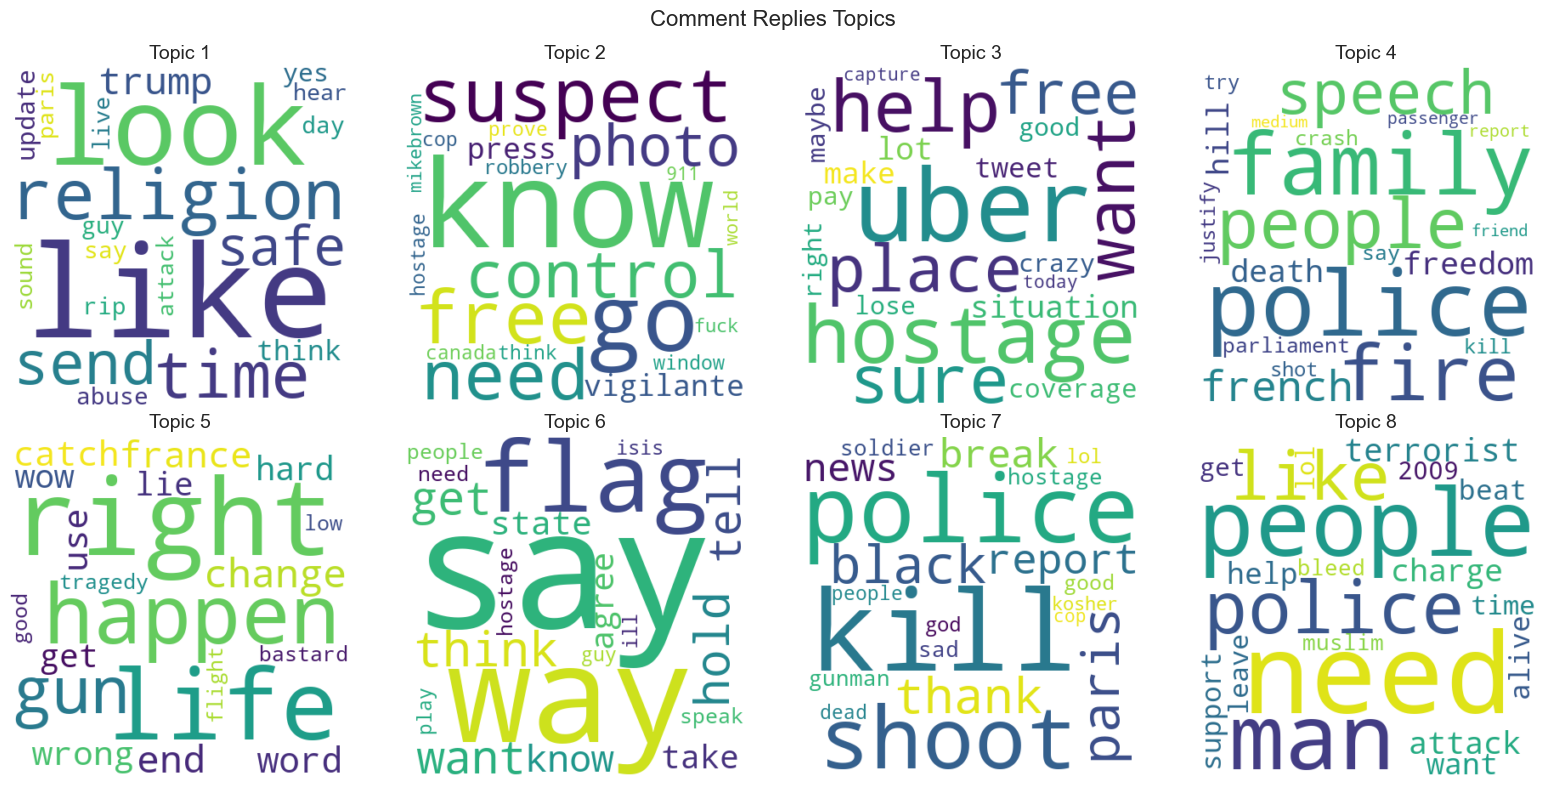

In [13]:
# wordclouds

# stance wordcloud
stance_topics = get_topic_words(stance_lda)
print_topics(stance_topics, "Stance Replies (S/D/Q)")

save_path = SAVE_DIR + "stance_wordcloud.png" if SAVE_DIR else None
create_wordcloud(stance_topics, "Stance Replies (S/D/Q) Topics", save_path)

# comment wordcloud
comment_topics = get_topic_words(comment_lda)
print_topics(comment_topics, "Comment Replies")

save_path = SAVE_DIR + "comment_wordcloud.png" if SAVE_DIR else None
create_wordcloud(comment_topics, "Comment Replies Topics", save_path)

In [10]:
# vis lda word lists with tmplot
import tmplot as tmp
tmp.report(stance_lda, corpus=stance_corpus, docs=stance_texts)

/Users/Subspace_Explorer/Documents/Programming/NLP_cswk/.venv/lib/python3.12/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [11]:
# comment lda vis
tmp.report(comment_lda, corpus=comment_corpus, docs=comment_texts)